In [26]:
import torch, torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split

import torch_geometric.nn as gnn
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.loader import DataLoader

from tqdm.auto import tqdm


import matplotlib.pyplot as plt
import numpy as np

from dataclasses import dataclass, field
from typing import List, Tuple
import os.path as osp
import os

In [27]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(1337)

In [28]:
torch.rand(10 , 2)

tensor([[0.0783, 0.4956],
        [0.6231, 0.4224],
        [0.2004, 0.0287],
        [0.5851, 0.6967],
        [0.1761, 0.2595],
        [0.7086, 0.5809],
        [0.0574, 0.7669],
        [0.8778, 0.2434],
        [0.6005, 0.7079],
        [0.5102, 0.4065]])

In [29]:
def plot_base(
    root: str,
    arr1: list,
    arr2: list,
    fig_name: str,
    title: str,
    x_label: str, 
    y_label: str,
    plot_label1: str,
    plot_label2: str,
):
    arr1 = np.array(arr1)
    arr2 = np.array(arr2)

    plt.plot(arr1, label= plot_label1)
    plt.plot(arr2, label= plot_label2)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    plt.legend(loc="upper left")

    plt.show()
    # plt.savefig(osp.join(root, f"{fig_name}.png"))
    # plt.clf() 

In [30]:
def plot_loss(
    root: str,
    train_loss: list,
    test_loss: list,
):
    
    plot_base(
        root= root,
        arr1= train_loss,
        arr2= test_loss,
        fig_name= "loss_plot",
        title= "Training and Testing Loss",
        x_label= "epochs",
        y_label= "loss",
        plot_label1= "Training Loss",
        plot_label2= "Testing Loss",
    )

## Preapre The Dataset

In [31]:
class TrsussDatasetForGCN(InMemoryDataset):

    def __init__(
            self,
            root: str,
            re_process: bool = False,
            transform=None,
            pre_transform=None,
            pre_filter=None
        ) -> None:
        
        if not (osp.exists(root) and not osp.exists(osp.join(root, "dataset" "raw"))):
            raise DatasetNotExist()
        
        super().__init__(root, transform, pre_transform, pre_filter, force_reload=re_process)
        
        self.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return sorted(os.listdir(self.raw_dir))

    @property
    def processed_file_names(self):
        return ['data.pt']

    def edge_index(self) -> torch.tensor:
        return torch.tensor([[0, 1, 1, 1],
                             [1, 0, 1, 1],
                             [1, 1, 0, 1],
                             [1, 1, 1, 0]]).nonzero(as_tuple=False).t().contiguous()

    def download(self):
        ...

    def process(self):

        data_list = []
        target = []
        
        data_tensors = torch.load(osp.join(self.root, "raw", self.raw_file_names[1]))

        target = torch.load(osp.join(self.root, "raw", self.raw_file_names[0]))

        for i in range(len(data_tensors)):

            data = Data(edge_index=self.edge_index(), x=data_tensors[i], y= target[i].unsqueeze(0).type(torch.float32))
            
            data_list.append(data)
            
        self.data, self.slices = self.collate(data_list)
            
        torch.save((self._data, self.slices), self.processed_paths[0])

In [32]:
dataset = TrsussDatasetForGCN(root= "./dataset")

In [33]:
dataset

TrsussDatasetForGCN(2001)

In [34]:
dataset[300].y

tensor([[0.0163, 0.3238]])

In [35]:
trainset, testset = random_split(dataset,  lengths=[0.8, 0.2])

In [36]:
train_loader = DataLoader(trainset, batch_size=100, shuffle=True)

In [139]:
test_loader = DataLoader(testset, batch_size=10, shuffle=True)

## Build The Model

First let's build the model configs

In [140]:
@dataclass
class GCNModelConfigs:
   
    gcn_layers: List[Tuple[int, int]] = field(default_factory=lambda: [(2, 64), (64, 32)])
    fc_layers: List[Tuple[int, int]] = field(default_factory=lambda: [(32, 32)])

    device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    target_dim: int = 2

    @staticmethod
    def get_defaults():
        return GCNModelConfigs()
    
    def to_dict(self):
        fc_layers = [*self.fc_layers, (self.fc_layers[-1][1], self.num_classes)]
        return {"gcn_layers": self.gcn_layers, "fc_layers": fc_layers, "device": str(self.device), "num_classes": self.num_classes}

Then Build the Model Architecture

In [184]:
class GCNModel(nn.Module):

    def __init__(self, configs: GCNModelConfigs = GCNModelConfigs.get_defaults()) -> None:
        super(GCNModel, self).__init__() 
        
        self.configs: GCNModelConfigs = configs

        self.gcn = gnn.Sequential('x, edge_index', [
            (self.gcn_conv_block(in_dim, out_dim), 'x, edge_index -> x') 
            for (in_dim, out_dim) in self.configs.gcn_layers
        ])

        self.fc = nn.Sequential(
            *[self.fc_block(in_dim, out_dim) for (in_dim, out_dim) in self.configs.fc_layers]
        )

        last_dim = self.configs.fc_layers[-1][1]

        self.fc.add_module(name= "out", module=nn.Linear(last_dim , self.configs.target_dim))

    def gcn_conv_block(self, in_dim: int, out_dim: int):
        return gnn.Sequential('x, edge_index', [
            (gnn.GCNConv(in_dim, out_dim), 'x, edge_index -> x'),
            nn.ReLU(True),
        ])

    def fc_block(self, in_dim: int, out_dim: int,):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.ReLU(True),
        )

    def forward(self, input: torch.Tensor, edge_index: torch.Tensor, batch: torch.Tensor) -> torch.Tensor:
        
        out = self.gcn(input, edge_index)
        out = gnn.global_max_pool(out, batch)
        
        return self.fc(out)

In [ ]:
model = GCNModel()

In [ ]:
model

In [ ]:
data = next(iter(train_loader))

In [ ]:
data

In [ ]:
model(data.x, data.edge_index, data.batch)[:10]

In [ ]:
loss_fn = nn.MSELoss()

In [191]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)

In [199]:
def train_step_gcn_model(
    model: nn.Module,
    loss_fn: nn.modules.loss._Loss,
    opt: optim.Optimizer,
    loader: DataLoader, 
    device: torch.device,
) -> None:
    
    for data in loader:

        opt.zero_grad()

        data = data.to(device)

        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fn(out, data.y)

        loss.backward()

        opt.step()

In [200]:
def compute_loss(
    model: nn.Module,
    loader: torch.utils.data.DataLoader,
    loss_fn: nn.modules.loss._Loss,
    device: torch.device
) -> float:
    
    model.eval()

    total_loss = 0
    accuracy = 0
    
    for data in loader:

        data = data.to(device)

        out = model(data.x, data.edge_index, data.batch)

        loss = loss_fn(out, data.y)

        total_loss += loss.item()

    return total_loss

In [201]:
def train_gcn_model(
    model: nn.Module,
    loss_fn: nn.modules.loss._Loss,
    opt: optim.Optimizer,
    lr_schedular: optim.lr_scheduler.LRScheduler,
    train_loader: DataLoader, 
    test_loader: DataLoader, 
    device: torch.device,
    epochs: int = 10
) -> None:

    results = {
        "train_loss": [],
        "test_loss": [],
    }

    for epoch in (bar := tqdm(range(epochs))):

        train_step_gcn_model(
            model= model,
            loss_fn= loss_fn,
            opt= opt,
            loader= train_loader,
            device= device
        )

        train_loss = compute_loss(
            model= model,
            loader= train_loader,
            loss_fn= loss_fn,
            device= device
        )

        test_loss = compute_loss(
            model= model,
            loader= test_loader,
            loss_fn= loss_fn,
            device= device
        )

        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

    return results

In [203]:
results = train_gcn_model(
    model= model,
    loss_fn= loss_fn, 
    opt= opt,
    lr_schedular= None,
    train_loader= train_loader,
    test_loader= test_loader,
    device= 'cpu',
    epochs= 100
)

  0%|          | 0/100 [00:00<?, ?it/s]

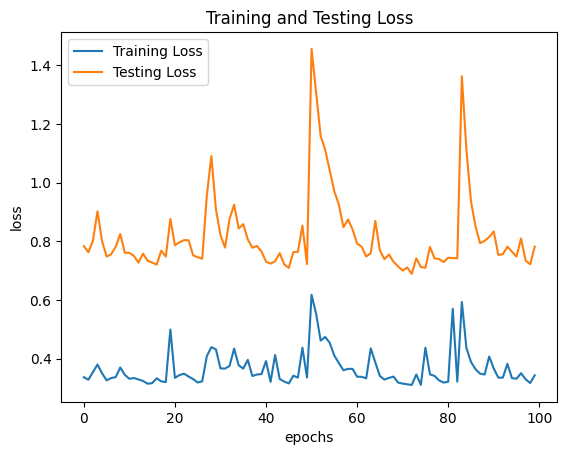

In [204]:
plot_loss(
    root= "./",
    train_loss= results["train_loss"],
    test_loss= results["test_loss"],
)